挂载Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# 创建文件夹，用于存储年报PDF
base_prefix = '/content/drive/MyDrive/demo'
report_path = 'report'
save_path = os.path.join(base_prefix,report_path)
if(not os.path.exists(save_path):
    os.makedirs(save_path)

## 1.爬取年报信息

In [17]:
pip install PyPDF2

In [20]:
from PyPDF2 import PdfFileReader
import random
import requests
import re
import time
import csv
import os

PAGESIZE = 30
MAX_RELOAD_TIMES = 5

UNEXPECTED_WORDS = ['通知', '公告', '取消', '摘要', '建议', '意见' '更正', '更新', '英文', '补充', '函件', '发函', '回函' '回条']

# PDF文件存储路径
base_prefix = '/content/drive/MyDrive/demo'
report_path = 'report'
save_path = os.path.join(base_prefix,report_path)
# PDF文件下载链接前缀
download_prefix = 'http://static.cninfo.com.cn'
# 公告信息链接
info_url = 'http://www.cninfo.com.cn/new/commonUrl/pageOfSearch?url=disclosure/list/search&checkedCategory=category_yjygjxz_szs'


# User-Agent 可通过 https://fake-useragent.herokuapp.com/browsers/0.1.11 查询
User_Agent = [
    "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)",
    "Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 1.0.3705; .NET CLR 1.1.4322)",
    "Mozilla/4.0 (compatible; MSIE 7.0b; Windows NT 5.2; .NET CLR 1.1.4322; .NET CLR 2.0.50727; InfoPath.2; .NET CLR 3.0.04506.30)",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3) Arora/0.3 (Change: 287 c9dfb30)",
    "Mozilla/5.0 (X11; U; Linux; en-US) AppleWebKit/527+ (KHTML, like Gecko, Safari/419.3) Arora/0.6",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8.1.2pre) Gecko/20070215 K-Ninja/2.1.1",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN; rv:1.9) Gecko/20080705 Firefox/3.0 Kapiko/3.0"
]


headers = {'Accept': 'application/json, text/javascript, */*; q=0.01',
           "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
           "Accept-Encoding": "gzip, deflate",
           "Accept-Language": "zh-CN,zh;q=0.9,en-US;q=0.8,en;q=0.7,zh-HK;q=0.6,zh-TW;q=0.5",
           'Host': 'www.cninfo.com.cn',
           'Origin': 'http://www.cninfo.com.cn',
           'Referer': 'http://www.cninfo.com.cn/new/commonUrl?url=disclosure/list/notice',
           'X-Requested-With': 'XMLHttpRequest'
           }

# 存储以及抓取的公司的ID
company_code = []

# 爬取深沪年报公告信息
def get_json(page_num, start_day='2019-06-01', end_day='2021-01-11', search_key='年报', sort_name='code', sort_type='asc', column='szse'):

    time.sleep(5)

    json_url = 'http://www.cninfo.com.cn/new/hisAnnouncement/query'
    headers['User-Agent'] = random.choice(User_Agent)
    from_data = {        
            'pageNum': page_num,
            'pageSize': PAGESIZE,
            'column': column,
            'tabName': 'fulltext',
            'plate': '', 
            'stock': '',
            'searchkey': search_key,
            'secid': '', 
            'category': 'category_ndbg_szsh', 
            'trade': '', 
            'seDate': start_day + '~' + end_day,
            'sortName': 'code',
            'sortType': 'asc',
    }
    reload_time = 0
    while(reload_time < MAX_RELOAD_TIMES):
        try:
            respon = requests.post(json_url, headers=headers, data=from_data)
        except Exception as e:
            print(e)
            continue
        if respon.status_code == 200:
            break
        else:
            
            reload_time += 1

    response_json = respon.json()
    try:
        respon.close()
    except Exception as e:
        print(e)

    for announcement in response_json['announcements']:
      if((not len(company_code) or announcement['secCode'] != company_code[-1]) and 'PDF' == announcement['adjunctType']):
          index = 0
          for idx in range(len(UNEXPECTED_WORDS)):
              if(not re.search(UNEXPECTED_WORDS[idx], announcement['announcementTitle'])):
                  index += 1
                  continue
              else:
                  break
          if(index != len(UNEXPECTED_WORDS)):
              break
          else:
              company_code.append(announcement['secCode'])
              download_link = download_prefix + '/' + announcement['adjunctUrl']
              file_name = announcement['secCode'] + '_' + announcement['secName'] + '_' + announcement['announcementTitle'] + '.PDF'
              file_name = file_name.replace(' ', '_').replace('/', '_')

              flag = False
              # 下载PDF
              download_pdf(download_link, file_name)
              # 获取PDF页码
              with open(save_path + "/"+file_name, "rb") as f:
                  reader = PdfFileReader(f, strict=False)
                  if reader.isEncrypted:
                      company_code.pop()
                      flag = True
              f.close()
              if(flag):
                  os.remove(save_path + "/"+file_name)  
                  continue


def download_pdf(download_link, name):
    
    reload_time = 0
    while(reload_time < MAX_RELOAD_TIMES):
      time.sleep(1)
      try:
          respon = requests.get(download_link)
      except Exception as e:
          print('Download' + name + 'failed!')
          print(e)
          reload_time += 1
          continue
      with open(save_path + '/' + name, 'wb') as file:
          file.write(respon.content)
          print(name + '\' downloaded.')
          break


i = 1
while(len(company_code) < 25):
    get_json(i)
    i += 1


000001_平安银行_2019年年度报告.PDF' downloaded.
000002_万__科Ａ_2019年年度报告.PDF' downloaded.
000004_国农科技_2019年年度报告.PDF' downloaded.
000019_深粮控股_2019年年度报告.PDF' downloaded.
000061_农_产_品_2019年年度报告.PDF' downloaded.
000153_丰原药业_2019年年度报告.PDF' downloaded.
000155_川能动力_2019年年度报告.PDF' downloaded.
000504_*ST生物_2019年年度报告.PDF' downloaded.
000505_京粮控股_2019年年度报告.PDF' downloaded.
000506_中润资源_2019年年度报告.PDF' downloaded.
000507_珠海港_2019年年度报告.PDF' downloaded.
000503_国新健康_2019年年度报告.PDF' downloaded.
000523_广州浪奇_2019年年度报告.PDF' downloaded.
000555_神州信息_2019年年度报告.PDF' downloaded.
000557_西部创业_2019年年度报告.PDF' downloaded.
000638_万方发展_2019年年度报告.PDF' downloaded.
000678_襄阳轴承_2019年年度报告.PDF' downloaded.
000728_国元证券_2019年年度报告.PDF' downloaded.
000851_高鸿股份_2019年年度报告.PDF' downloaded.
000936_华西股份_2019年年度报告.PDF' downloaded.
000910_大亚圣象_2019年年度报告.PDF' downloaded.
000951_中国重汽_2019年年度报告.PDF' downloaded.
000967_盈峰环境_2019年年度报告.PDF' downloaded.
000968_蓝焰控股_2019年年度报告.PDF' downloaded.
002003_伟星股份_2019年年度报告.PDF' downloaded.
002004_华邦健康_2019年年度报告.P

## 2.读取PDF文件，获取基本信息

安装 pdfplumber 依赖

In [ ]:
pip install pdfplumber

创建CSV表格，用于存储数据

In [21]:
import os
import csv
base_prefix = '/content/drive/MyDrive/demo'
file_names = ['profile.csv', 'data.csv']
csv_titiles = [['股票简称', '股票代码', '公司的法定代表人', '办公地址', '公司网址', '电子信箱'], ['2019年', '2018年', '本年比上年增减', '2017年']]

for (fname, titlerow) in zip(file_names, csv_titiles):
    tmp_path = os.path.join(base_prefix,fname)

    # 删除并重新创建csv文件
    if(os.path.isfile(tmp_path)):
        os.remove(tmp_path)
    with open(tmp_path, mode="w", encoding='utf-8-sig') as fd:
        fd.close()

    # 写入CSV文件表头
    with open(tmp_path, 'a', newline='', encoding='utf-8-sig') as file:
        writer = csv.writer(file)
        writer.writerow(titlerow)
    file.close()

遍历所有的PDF文件，提取信息
公司基本情况
主要会计数据和财务指标


In [23]:
import os
import re
import csv
import pdfplumber
# PDF文件存储路径
EXPECTED_INFO = ['股票简称', '股票代码', '公司的法定代表人', '办公地址', '公司网址', '电子信箱', '归属于上市公司股东的扣除非']
KEY_WORDS = ['股票简称', '营业收入（元）']
base_prefix = '/content/drive/MyDrive/demo'
report_path = 'report'
save_path = os.path.join(base_prefix,report_path)

file_names = ['profile.csv', 'data.csv']

for root, dirs, files in os.walk(save_path, topdown=False):
    for name in files:
        if('PDF' != name.split('.')[-1]):
            continue

        file_path = os.path.join(root, name)
        print(file_path)
        index = 0
        flag1 = False
        flag2 = False
        res1 = [''for _ in range(6)]
        res2 = [''for _ in range(4)]
        with pdfplumber.open(file_path) as pdf:

            for idx in range(2, 10):
                for table in pdf.pages[idx].extract_tables():
                    if(len(table) > 5 and (table[0][0] if table[0][0] else '').strip().replace("\n", "") == KEY_WORDS[0]):
                        # df = pd.DataFrame(table[1:], columns=table[0]) 
                        # print(df)
                        print(table)
                        res1[0] = table[0][1]
                        res1[1] = table[0][3]
                        tmp = 2
                        for row in range(1, len(table)):
                            row_0 = (table[row][0] if table[row][0] else '').strip().replace("\n", "")
                            if(row_0 == EXPECTED_INFO[2]):
                                res1[2] = table[row][1]
                                tmp += 1
                            elif(row_0 == EXPECTED_INFO[3]):
                                res1[3] = table[row][1]
                                tmp += 1
                            elif(row_0 == EXPECTED_INFO[4]):
                                res1[4] = table[row][1]
                                tmp += 1
                            elif(row_0 == EXPECTED_INFO[5]):
                                res1[5] = table[row][1]
                                tmp += 1
                            if(tmp == 6):
                                flag1 = True
                                break

                    elif(len(table) > 2 and len(table[0]) == 5 and (table[1][0] if table[1][0] else '').strip().replace("\n", "") == KEY_WORDS[1]):
                        # df = pd.DataFrame(table[1:], columns=table[0]) 
                        # print(df)
                        print(table)
                        for row in range(1, len(table)):
                            row_0 = (table[row][0] if table[row][0] else '').strip().replace("\n", "")
                            if(re.match(EXPECTED_INFO[-1], row_0) is not None):
                                row_tmp = row
                                while(1):
                                    if(table[row_tmp][1] is None or table[row_tmp][1] == ''):
                                        row_tmp += 1
                                    else:
                                        break
                                for i in range(4):
                                    res2[i] = table[row_tmp][1+i]
                                flag2 = True

                    else:
                        continue
                    
                    if(flag1 and flag2):
                        break
                if(flag1 and flag2):
                    break
        if(flag1 and flag2):
            with open(os.path.join(base_prefix,file_names[0]), 'a', newline='', encoding='utf-8-sig') as file1:
                writer = csv.writer(file1)
                writer.writerow([res1[0], res1[1], res1[2], res1[3], res1[4], res1[5]])
            file1.close()
            with open(os.path.join(base_prefix,file_names[1]), 'a', newline='', encoding='utf-8-sig') as file2:
                writer = csv.writer(file2)
                writer.writerow([res2[0], res2[1], res2[2], res2[3]])
            file2.close()
        pdf.close()

/content/drive/MyDrive/demo/report/000001_平安银行_2019年年度报告.PDF
[['股票简称', '平安银行', '股票代码', '000001'], ['股票上市证券交易所', '深圳证券交易所', None, None], ['公司的中文名称', '平安银行股份有限公司', None, None], ['公司的中文简称', '平安银行', None, None], ['公司的外文名称', 'Ping An Bank Co., Ltd.', None, None], ['公司的外文名称缩写', 'PAB', None, None], ['公司的法定代表人', '谢永林', None, None], ['注册地址', '中华人民共和国广东省深圳市罗湖区深南东路5047 号', None, None], ['注册地址的邮政编码', '518001', None, None], ['办公地址', '中国广东省深圳市深南东路5047 号 \n中国广东省深圳市福田区益田路5023 号平安金融中心B座', None, None], ['办公地址的邮政编码', '518001、518033', None, None], ['公司网址', 'http://bank.pingan.com', None, None], ['电子信箱', 'PAB_db@pingan.com.cn', None, None], ['服务热线', '95511 转3', None, None]]
/content/drive/MyDrive/demo/report/000002_万__科Ａ_2019年年度报告.PDF
/content/drive/MyDrive/demo/report/000004_国农科技_2019年年度报告.PDF
[['股票简称', '国农科技', '股票代码', '000004'], ['股票上市证券交易所', '深圳证券交易所', None, None], ['公司的中文名称', '深圳中国农大科技股份有限公司', None, None], ['公司的中文简称', '国农科技', None, None], ['公司的外文名称（如有）', 'SHENZHEN CAU TECHNOLOGY CO., LTD', None, None],

## 3. 利用CSV文件画图

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


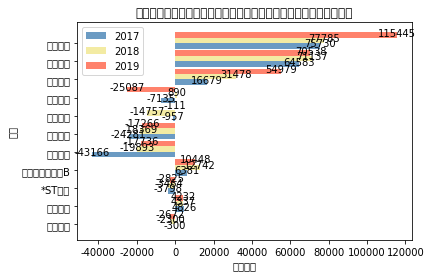

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

base_prefix = '/content/drive/MyDrive/demo'
file_names = ['profile.csv', 'data.csv']

exp_data = pd.read_csv(os.path.join(base_prefix,file_names[1]), header=0)
tmp_2019 = [int(str.replace(',', '')[:-7]) for str in exp_data['2019年'].values.tolist()]
tmp_2018 = [int(str.replace(',', '')[:-7]) for str in exp_data['2018年'].values.tolist()]
tmp_2017 = [int(str.replace(',', '')[:-7]) for str in exp_data['2017年'].values.tolist()]
exp_title = pd.read_csv(os.path.join(base_prefix,file_names[0]), header=0)
tmp_title = [str for str in exp_title['股票简称'].values.tolist()]

x_data = tmp_title
y1 = tmp_2017
y2 = tmp_2018
y3 = tmp_2019

bar_width = 0.3

plt.barh(y=range(len(x_data)), width=y1, label='2017', color='steelblue', alpha=0.8, height=bar_width)
plt.barh(y=np.arange(len(x_data))+bar_width, width=y2, label='2018', color='khaki', alpha=0.8, height=bar_width)
plt.barh(y=np.arange(len(x_data))+bar_width*2, width=y3, label='2019', color='tomato', alpha=0.8, height=bar_width)


for y, x in enumerate(y1):
    plt.text(x, y-bar_width/2, '%s' % x, ha='center', va='bottom')
for y, x in enumerate(y2):
    plt.text(x, y+bar_width/2, '%s' % x, ha='center', va='bottom')

for y, x in enumerate(y3):
    plt.text(x, y+bar_width/2*3, '%s' % x, ha='center', va='bottom')

plt.yticks(np.arange(len(x_data))+bar_width/2, x_data)
# 设置标题
plt.title("最近三年归属于上市公司股东的扣除非经常性损益的净利润（万元）")
# 为两条坐标轴设置名称
plt.ylabel("公司")
plt.xlabel("（万元）")
# 显示图例
plt.legend()
plt.show()

绝大部分公司归属于上市公司股东的扣除非经常性损益的净利润都在增加